In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta
from pytz import timezone

import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [2]:
# read in data and rename column
df=pd.read_csv('dfw_d_high95.csv')
df.rename(columns={'MACHINEID':'EVENT_KEY','CREATIONTIME':'EVENT_DATE'},inplace=True)

df.head()

,EVENT_DATE,DENSITY,EVENT_KEY
0,1/21/21 0:00,353,7
1,1/21/21 3:00,374,7
2,1/21/21 6:00,131,7
3,1/21/21 9:00,21,7
4,1/21/21 12:00,1040,7


In [3]:
# find min and max datetime in data and change to datetime format
print(min(df['EVENT_DATE']),'-',max(df['EVENT_DATE']))
df['EVENT_DATE']=pd.to_datetime(df['EVENT_DATE'])

df.head()

1/21/21 0:00 - 6/9/21 9:00


,EVENT_DATE,DENSITY,EVENT_KEY
0,2021-01-21 00:00:00,353,7
1,2021-01-21 03:00:00,374,7
2,2021-01-21 06:00:00,131,7
3,2021-01-21 09:00:00,21,7
4,2021-01-21 12:00:00,1040,7


In [4]:
total_day=(max(df['EVENT_DATE']) - min(df['EVENT_DATE'])).days
print(total_day)

160


In [5]:
# import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
# empty dataframe to append forecast results
Final=pd.DataFrame()

In [7]:
# find unique events
Event_List=list(df['EVENT_KEY'].unique())
print(Event_List)

[7, 8]


In [8]:
# length of training period (days) - 70% of total days
training_period=round(0.7*total_day,0) 

# training interval increment (days)
interval=7

# window between checkpoint (hours)
window='6H'

#number of forecast (based on windows between checkpoint)
number_of_forecast = 24/int(window[0])

for evnt in Event_List:
    print('Machine ',evnt)

    # sort tracking event by key
    pre_train=df[df['EVENT_KEY']==evnt]

    #drop Event_Key column
    pre_train.drop(['EVENT_KEY'],axis=1,inplace=True) 

    # the n+1 day - the day after as a start date for forecasting
    min_val=(min(pre_train['EVENT_DATE'])+timedelta(days=1)).round('D')
    max_val=max(pre_train['EVENT_DATE'])

    temp=pd.DataFrame()

    # sort datetime by Event_Key
    # 6-hour increment
    temp['EVENT_DATE']=pd.Series(pd.date_range(min_val,max_val,freq=window))

    pre_train=pre_train.merge(temp,how='right',left_on='EVENT_DATE',right_on='EVENT_DATE')
    pre_train['EVENT_DATE']=pre_train['EVENT_DATE'].fillna(0)

    # training period
    len_train=pd.to_datetime(min_val)+timedelta(days=training_period) 
    flag=len_train

#     pre_train.dropna(inplace=True)
    pre_train=pre_train.sort_values(['EVENT_DATE'])

    while (flag+timedelta(days=interval))<=pd.to_datetime(max_val):
        forecast=pd.DataFrame()

        # training set with datetime smaller than flag
        # rename column and convert to datetime format
        train=pre_train[pre_train['EVENT_DATE']<flag]
        train.columns = ['ds', 'y']
        train['ds']= pd.to_datetime(train['ds'])

        # define the model
        model = Prophet()
#         daily_seasonality=True
#         yearly_seasonality=False

        # fit the model
        model.fit(train)

        # future dataframe with the beginning of training period as a start date
        # 6-hourly period in 7 days
        future=pd.DataFrame(pd.Series(pd.date_range(start=flag, periods=number_of_forecast*interval,freq=window)),columns=['ds'])

        forecast = model.predict(future)
        forecast['Event']=evnt

        #append forecast result
        Final=Final.append(forecast)
        flag=flag+timedelta(days=interval)

Event  7


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Event  8


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [9]:
# final y-hat=0 if smaller than 0
Final['yhat']=np.where(Final['yhat']<0,0,Final['yhat'])

df_t=df
df_t['EVENT_DATE']=pd.to_datetime(df_t['EVENT_DATE'])

Final_CSV=Final.merge(df_t,how='left',left_on=['ds','Event'],right_on=['EVENT_DATE','EVENT_KEY'])
Final_CSV['DENSITY']=Final_CSV['DENSITY'].fillna(0)
Final_CSV.to_csv('DensityHigh_Anomaly_Output_7Day.csv')

In [10]:

final_event_list=list(Final_CSV['Event'].unique())
print(final_event_list)

total_final_day=(max(Final_CSV['ds']) - min(Final_CSV['ds'])).days
print(total_final_day)

[7, 8]
41


In [11]:
# cleaning before visualization

# no negative volume: 0 for yhat_lower < 0
Final_CSV['yhat_lower']=np.where(Final_CSV['yhat_lower']<0,0,Final_CSV['yhat_lower'])

# round to nearest int
# Final_CSV.yhat_upper=Final_CSV.yhat_upper.round(decimals=0)
# Final_CSV.yhat_lower=Final_CSV.yhat_lower.round(decimals=0)
# Final_CSV.yhat=Final_CSV.yhat.round(decimals=0)

# Final_CSV.head()
Final_CSV.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Event,EVENT_DATE,DENSITY,EVENT_KEY
331,2021-06-23 18:00:00,172.258460,0.0,540.664764,171.766294,172.656371,-24.867717,-24.867717,-24.867717,-68.367099,...,43.499382,43.499382,0.0,0.0,0.0,147.390743,8,2021-06-23 18:00:00,212,8
332,2021-06-24 00:00:00,172.309077,0.0,490.146133,171.769306,172.734605,-80.173780,-80.173780,-80.173780,-122.144883,...,41.971104,41.971104,0.0,0.0,0.0,92.135297,8,2021-06-24 00:00:00,2,8
333,2021-06-24 06:00:00,172.359693,0.0,444.531010,171.784494,172.813547,-119.126417,-119.126417,-119.126417,-148.008162,...,28.881745,28.881745,0.0,0.0,0.0,53.233277,8,2021-06-24 06:00:00,0,8
334,2021-06-24 12:00:00,172.410310,0.0,526.390013,171.801165,172.902215,-42.189920,-42.189920,-42.189920,-51.959316,...,9.769396,9.769396,0.0,0.0,0.0,130.220390,8,2021-06-24 12:00:00,413,8
335,2021-06-24 18:00:00,172.460927,0.0,470.292757,171.811216,172.994866,-75.568274,-75.568274,-75.568274,-68.367099,...,-7.201175,-7.201175,0.0,0.0,0.0,96.892653,8,2021-06-24 18:00:00,177,8


Event  7


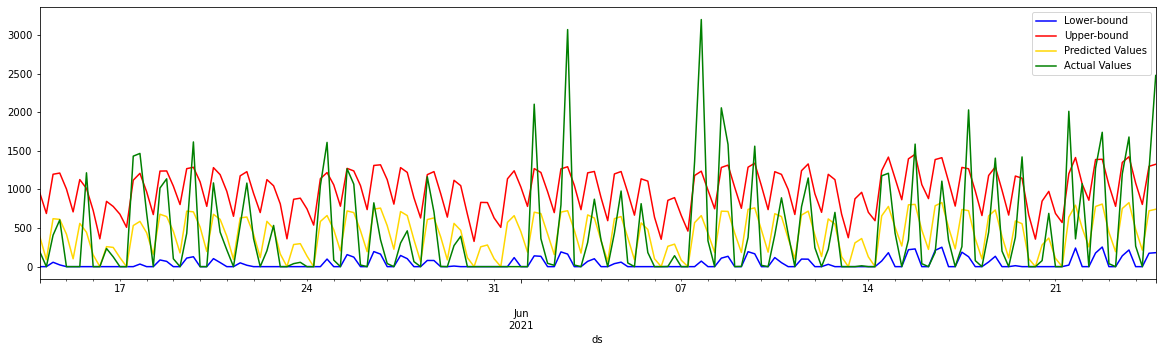

Event  8


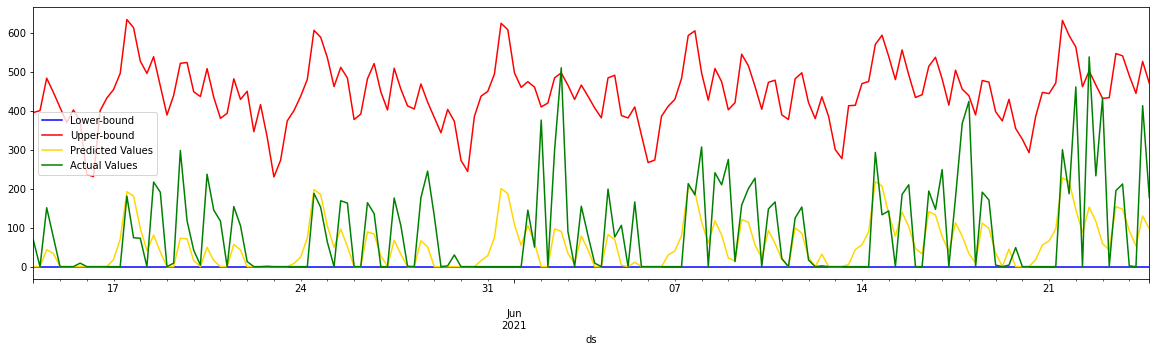

In [12]:
#all time - graph plot with date, confidence interval, predicted and actual values

for final_evnt in final_event_list:
    print('Machine ',final_evnt) 

    spec_event=Final_CSV[Final_CSV['Event'] == final_evnt]

    ax = plt.gca()

    spec_event.plot(kind='line',x='ds',y='yhat_lower', color='blue', label='Lower-bound', ax=ax, figsize=(20, 5))
    spec_event.plot(kind='line',x='ds',y='yhat_upper', color='red', label='Upper-bound', ax=ax, figsize=(20, 5))

    spec_event.plot(kind='line',x='ds',y='yhat', color='gold', label='Predicted Values', ax=ax, figsize=(20, 5))
    spec_event.plot(kind='line',x='ds',y='DENSITY', color='green', label='Actual Values', ax=ax, figsize=(20, 5))

    plt.fill_between(spec_event.index, spec_event.yhat_upper, spec_event.yhat_lower, facecolor='orange',alpha=0.5)

    plt.show()

Event  7


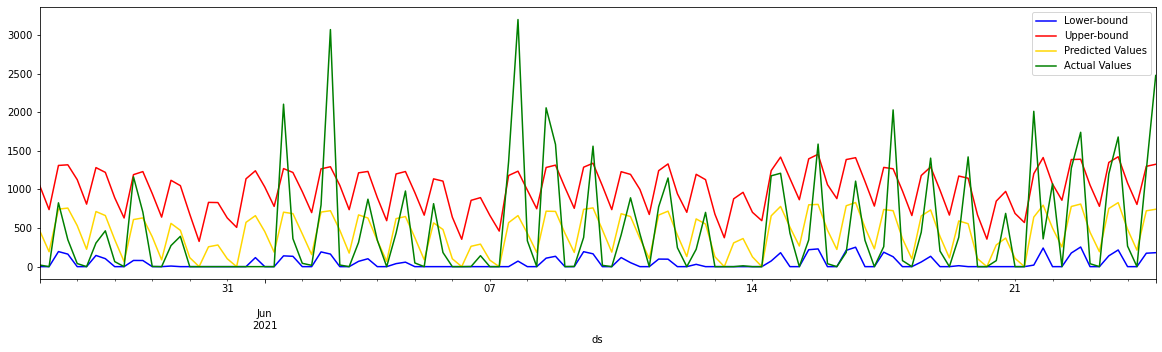

Event  8


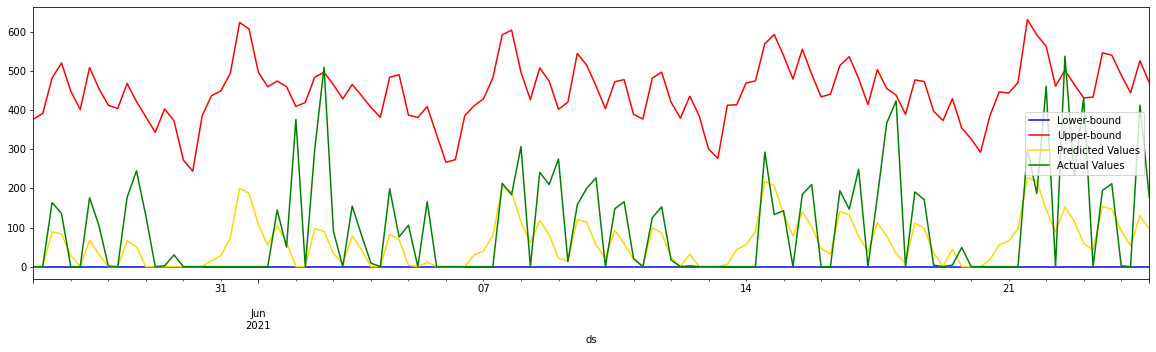

In [15]:
#most recent 30 days - graph plot with date, confidence interval, predicted and actual values

for final_evnt in final_event_list:
    print('Machine ',final_evnt) 

    spec_event=Final_CSV[Final_CSV['Event'] == final_evnt]
    
    recent_30d = spec_event[(spec_event['ds'] > spec_event['ds'].iloc[-1]-timedelta(days=30))
                         & (spec_event['ds'] <= spec_event['ds'].iloc[-1])]
    
    ax = plt.gca()

    recent_30d.plot(kind='line',x='ds',y='yhat_lower', color='blue', label='Lower-bound', ax=ax, figsize=(20, 5))
    recent_30d.plot(kind='line',x='ds',y='yhat_upper', color='red', label='Upper-bound', ax=ax, figsize=(20, 5))

    recent_30d.plot(kind='line',x='ds',y='yhat', color='gold', label='Predicted Values', ax=ax, figsize=(20, 5))
    recent_30d.plot(kind='line',x='ds',y='DENSITY', color='green', label='Actual Values', ax=ax, figsize=(20, 5))

    plt.fill_between(recent_30d.index, recent_30d.yhat_upper, recent_30d.yhat_lower, facecolor='orange',alpha=0.5)

    plt.show()

In [14]:
# all time metrics
y_pred=Final_CSV['yhat']
y_actual=Final_CSV['DENSITY']
sample=len(Final_CSV.index)

mse = mean_squared_error(y_actual,y_pred)
rmse = math.sqrt(mse/sample)
rse = math.sqrt(mse/(sample-2))
r2=r2_score(y_actual,y_pred)
mae=mean_absolute_error(y_actual,y_pred)
median_ae=median_absolute_error(y_actual, y_pred)
mask=y_actual!=0
mape=(np.fabs((y_actual-y_pred)/y_actual))[mask].mean()
mpe=((y_actual-y_pred)/y_actual)[mask].mean()
med_ape=(np.fabs((y_actual-y_pred)/y_actual))[mask].median()
forecast_error = [y_actual[i]-y_pred[i] for i in range(len(y_pred))]
mean_forecast_error=sum(forecast_error)/len(y_pred)
smape=1/len(y_actual) * np.sum(2 * np.abs(y_pred-y_actual) / (np.abs(y_actual) + np.abs(y_pred))*100)
wape=np.sum(np.abs(y_actual-y_pred))/np.sum(np.abs(y_actual))
msle=mean_squared_log_error(y_actual, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('RSE: ', rse)
print('R^2: ', r2)
print('MAE: ', mae)
print('Median_AE: ', median_ae)
print('MPE: ', mpe)
print('MAPE:', mape)
print('MdAPE:', med_ape)
print('Mean Forecast Error: ', mean_forecast_error)
print('SMAPE: ', smape)
print('WAPE: ', wape)
print('MSLE: ', msle)
print('RMSLE: ', np.sqrt(msle))

MSE:  136746.4168208738
RMSE:  20.173829170374614
RSE:  20.234139706034817
R^2:  0.45274333798062205
MAE:  206.55330534471375
Median_AE:  102.90331866089544
MPE:  -4.935655735316969
MAPE: 5.626341489732345
MdAPE: 0.6182451602026087
Mean Forecast Error:  37.27078042638972
SMAPE:  102.98345723209738
WAPE:  0.7475754082018163
MSLE:  6.950482048857553
RMSLE:  2.6363766894845573
